In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from time import time
from scipy import interp
import os
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, precision_score, accuracy_score, average_precision_score
from itertools import cycle
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
font = {'family' : 'Verdana',
#         'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

In [3]:
from matching import Matching
from rail import Path, Rail
from xml_loader import load, xml_dump
from sklearn.svm import SVC

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [5]:
matching = Matching(5)

In [6]:
def preprocess_object(obj):
    # assert obj==Rail
    for i, point in enumerate(obj.points):
        if 4 in point.channels:
            point.channels[2].signals = [sig for sig in point.channels[4].signals]
        if 5 in point.channels:
            point.channels[2].signals = [sig for sig in point.channels[5].signals]
        for ch in [0,1,3,4,5,6,7]:
            if ch in point.channels:
                point.channels.pop(ch, None)
    return obj

In [7]:
# cl = Classifier('D:/CMC_MSU/master/science/data/train_data_merge')
obj_path = 'D:/CMC_MSU/master/science/data/train_data_merge'
file_list = [obj_path + '/' + name for i, name in enumerate(os.listdir(obj_path))]
obj_list = [load(fname) for fname in file_list]
# y = np.array([1. if name.endswith('.def') else -1. for name in cl.file_list])
# X = np.array([cl.preprocess_object(obj.rails[0]) for obj in obj_list])
y = [1. if name.endswith('.def') else -1. for name in file_list]
X = [preprocess_object(obj.rails[0]) for obj in obj_list]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [9]:
def my_ker():
    alpha = 0.01
    return lambda x, y: \
        np.exp(- alpha * self.matching.gpu_match(self.matching.get_distance_table(x, y, 2, 5), distance=True))

In [10]:
def train_gram_matrix(X, _print=False):
    alpha = 0.05
    n_samples = len(X)
    K = np.zeros((n_samples, n_samples))
    # TODO(tulloch) - vectorize

    start = time()
    print('Sample len:', len(X))
    for i, x_i in enumerate(X):
        for j, x_j in enumerate(X):
            if i < j:
                K[i, j] = np.exp(- alpha * matching.gpu_match(matching.get_distance_table(x_i, x_j, 2, 5), distance=True))
                K[j, i] = K[i, j]
            elif i == j:
                K[i, j] = 1.
        if i % 100 == 0:
            print(i, time() - start)
            start = time()
    print('Kernel calculation finished')
    return K

def test_gram_matrix(x_test, x_train, _print=False):
    alpha = 0.005
    n_samples = len(x_test)
    m = len(x_train)
    K = np.zeros((n_samples, m))
    # TODO(tulloch) - vectorize

    start = time()
    print('Sample len:', len(x_test))
    for i, x_i in enumerate(x_test):
        for j, x_j in enumerate(x_train):
                K[i, j] = np.exp(- alpha * matching.gpu_match(matching.get_distance_table(x_i, x_j, 2, 5), distance=True))
        if i % 100 == 0:
            print(i, time() - start)
            start = time()
    print('Kernel calculation finished')
    return K

In [ ]:
train_k = train_gram_matrix(X_train)

In [15]:
test_k = test_gram_matrix(X_test, X_train)

Sample len: 92
0 0.7844736576080322
Kernel calculation finished


Sample len: 244
0 0.9324591159820557
100 41.74942994117737
200 23.181063890457153
Kernel calculation finished
Sample len: 62
0 0.39836692810058594
Kernel calculation finished
Sample len: 244
0 0.4733138084411621
100 44.03644418716431
200 24.254011392593384
Kernel calculation finished
Sample len: 62
0 0.44675517082214355
Kernel calculation finished
Sample len: 245
0 0.4889652729034424
100 44.60190939903259
200 28.85957098007202
Kernel calculation finished
Sample len: 61
0 0.44482421875
Kernel calculation finished
Sample len: 245
0 0.5008347034454346
100 45.46601128578186
200 26.35837459564209
Kernel calculation finished
Sample len: 61
0 0.4557030200958252
Kernel calculation finished
Sample len: 246
0 0.5183963775634766
100 48.792381286621094
200 30.18611216545105
Kernel calculation finished
Sample len: 60
0 0.6612954139709473
Kernel calculation finished
578.3801627159119


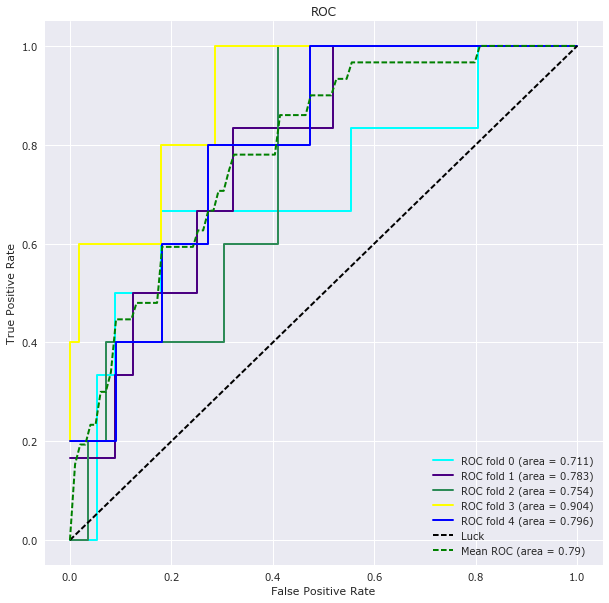

In [52]:
plt.figure(figsize=(10,10))
X = np.array(X)
y = np.array(y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=133)
clf = SVC(kernel=str('precomputed'), C=1.0, class_weight={1: 1, -1: 0.2}, random_state=133)
clf.probability = True
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2
i = 0
start = time()
for (train, test), color in zip(cv.split(X, y), colors):
#     print(list(y[train]).count(1.))
#     break
    X_train = train_gram_matrix(X[train])
    X_test = test_gram_matrix(X[test], X[train])
    
    probas_ = clf.fit(X_train, y[train]).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.3f)' % (i, roc_auc))

    i += 1
print(time() - start)
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('auc5fold2.png')
plt.show()

In [50]:
sum(np.linalg.eigvals(X_train)<0)

29

In [16]:
np.where(np.array(y_test)==1.0)

(array([ 0, 11, 12, 27, 42, 54, 75], dtype=int64),)

In [56]:
def calc_auc(x,y,fitted):
    probas = fitted.predict_proba(x)
    fpr, tpr, thresholds = roc_curve(y, probas[:, 1])
    roc_auc  = auc(fpr, tpr)
    return roc_auc, fpr, tpr

In [84]:
# w_train = [0.1 if y==-1 else 1 for y in y_train]
clf = SVC(kernel=str('precomputed'), C=1.0, class_weight={1: 1, -1: 0.1}, random_state=2)
clf.probability = True
fitted = clf.fit(train_k, y_train)#, sample_weight=w_train)
# probas = fitted.predict_proba(test_k)
# fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
# roc_auc  = auc(fpr, tpr)
# print(roc_auc)
roc_train, fpr_train, tpr_train = calc_auc(train_k, y_train, fitted)
roc_test, fpr_test, tpr_test = calc_auc(test_k, y_test, fitted)

In [61]:
roc_train, roc_test

(0.90902061855670091, 0.88403361344537823)

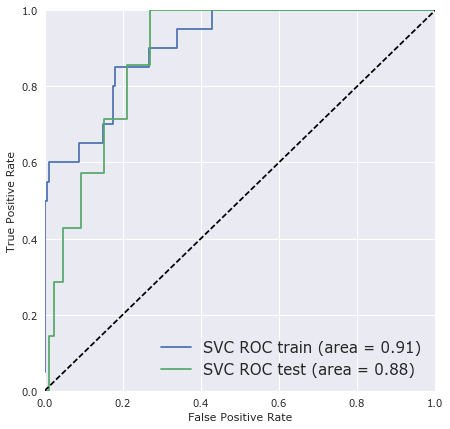

In [72]:
plt.figure(figsize=(7,7))
_ = plt.plot(fpr_train, tpr_train, label='%s ROC train (area = %0.2f)' % ('SVC', roc_train))
_ = plt.plot(fpr_test, tpr_test, label='%s ROC test (area = %0.2f)' % ('SVC', roc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

In [75]:
prob = fitted.predict_proba(test_k)
accuracy_score(y_test, prob[:, 1], normalize=True, sample_weight=[0.1 if y==-1. else 1 for y in y_test])

ValueError: Can't handle mix of binary and continuous-multioutput

In [66]:
prob = fitted.predict_proba(test_k)
precision, recall, _ = precision_recall_curve(y_test, prob[:, 1])

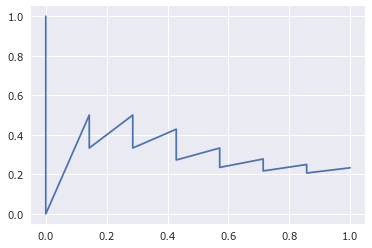

In [70]:
plt.plot(recall, precision)